In [ ]:
!pip install segmentation-models-pytorch

In [ ]:
pip install opencv-python


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Specify the main dataset path
dataset_path = '/content/drive/MyDrive/dataset'

In [ ]:
import os                       #os: For interacting with the operating system.
import matplotlib.pyplot as plt #matplotlib.pyplot: For plotting images.
import numpy as np              #numpy: For numerical operations.
import seaborn as sns           #seaborn for statistical data visualization.
import tensorflow as tf         #tensorflow: Deep learning library.
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.optimizers import Adam
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
#compute_class_weight from sklearn.utils.class_weight: For computing class weights.

import cv2


from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dense,Activation,Flatten,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping



In [ ]:
np.random.seed(12049)

In [ ]:
# List all directories (subfolders) in the dataset_path
subfolders = [f.name for f in os.scandir(dataset_path) if f.is_dir()]

print("Subfolders in the dataset:")
print(subfolders)

Subfolders in the dataset:
['1Doubtful', '4Severe', '3Moderate', '0Normal', '2Mild']


In [ ]:
# Count number of images in each subfolder
for folder in subfolders:
    folder_path = os.path.join(dataset_path, folder)
    num_images = len(os.listdir(folder_path))
    print(f"Number of images in {folder}: {num_images}")

Number of images in 1Doubtful: 1453
Number of images in 4Severe: 607
Number of images in 3Moderate: 663
Number of images in 0Normal: 1155
Number of images in 2Mild: 695


In [ ]:
categories = os.listdir(dataset_path)
labels = [i for i in range(len(categories))]

label_dict = dict(zip(categories, labels))  # empty dictionary
print("Label Dictionary:")
print(label_dict)
print("Categories:")
print(categories)
print("Labels:")
print(labels)

Label Dictionary:
{'1Doubtful': 0, '4Severe': 1, '3Moderate': 2, '0Normal': 3, '2Mild': 4}
Categories:
['1Doubtful', '4Severe', '3Moderate', '0Normal', '2Mild']
Labels:
[0, 1, 2, 3, 4]


In [ ]:
img_size = 256
data_before_resize = []
data_after_resize = []
label = []

for category in categories:
    folder_path = os.path.join(dataset_path, category)
    img_names = os.listdir(folder_path)

    for img_name in img_names:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
        try:
            # Preprocessing steps before resizing
            data_before_resize.append(img)

            # Preprocessing steps
            # Convert to grayscale
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # Resize
            resized = cv2.resize(gray, (img_size, img_size))

            # Append preprocessed image and label to lists
            data_after_resize.append(resized)
            label.append(label_dict[category])

        except Exception as e:
            print('Exception:', e)

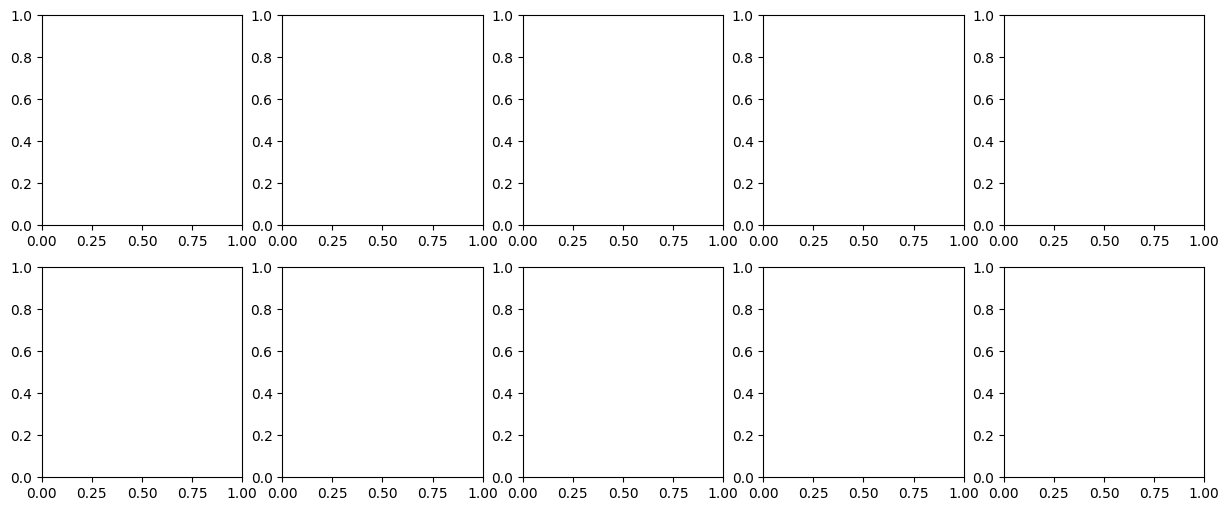

In [ ]:
# Display images and their dimensions
num_images_to_display = 5  # Number of images to display
fig, axes = plt.subplots(2, num_images_to_display, figsize=(15, 6))


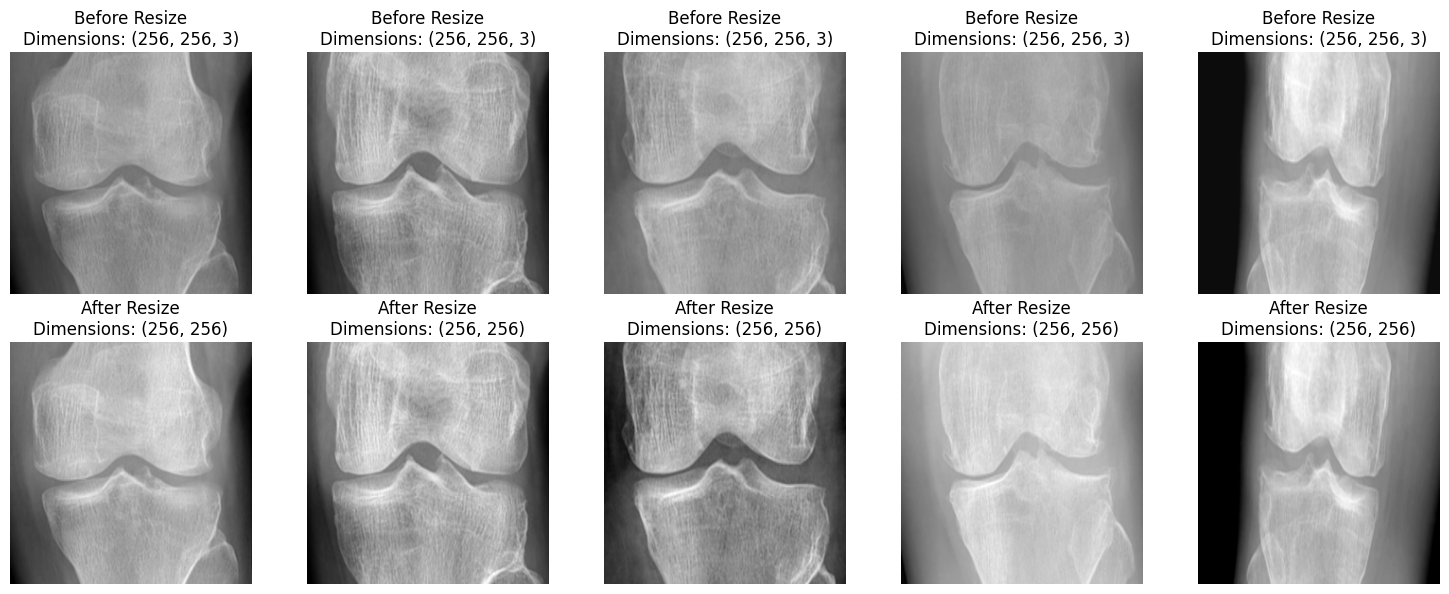

In [ ]:
# Display images and their dimensions
num_images_to_display = 5  # Number of images to display
fig, axes = plt.subplots(2, num_images_to_display, figsize=(15, 6))

for i in range(num_images_to_display):
    axes[0, i].imshow(cv2.cvtColor(data_before_resize[i], cv2.COLOR_BGR2RGB))
    axes[0, i].axis('off')  # Turn off axis
    axes[0, i].set_title(f"Before Resize\nDimensions: {data_before_resize[i].shape}")

    axes[1, i].imshow(data_after_resize[i], cmap='gray')
    axes[1, i].axis('off')  # Turn off axis
    axes[1, i].set_title(f"After Resize\nDimensions: {data_after_resize[i].shape}")

plt.tight_layout()
plt.show()

In [ ]:
print(type(img))

<class 'numpy.ndarray'>


In [ ]:
import numpy as np

# Normalization
data_after_resize = np.array(data_after_resize) / 255.0

In [ ]:
# Check mean and standard deviation of the normalized data
mean_value = np.mean(data_after_resize)
std_deviation = np.std(data_after_resize)

print("Mean:", mean_value)
print("Standard Deviation:", std_deviation)

Mean: 0.8304059359045952
Standard Deviation: 0.29844833727971404


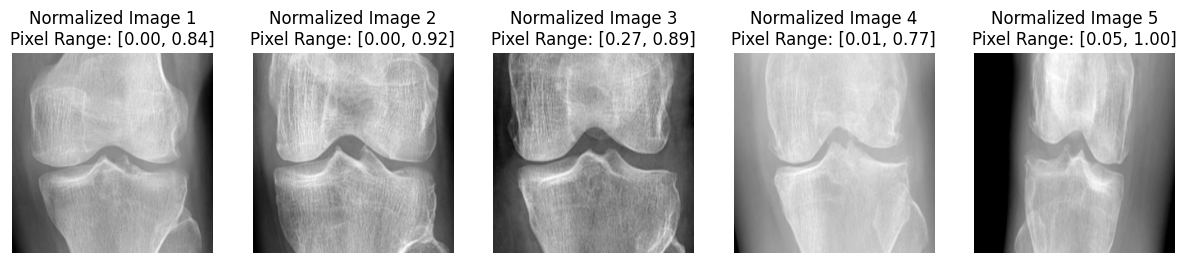

In [ ]:
# Display normalized images and their pixel value range-updated
num_images_to_display = 5  # Number of images to display
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 3))

for i in range(num_images_to_display):
    axes[i].imshow(data_after_resize[i], cmap='gray')
    axes[i].axis('off')  # Turn off axis
    axes[i].set_title(f"Normalized Image {i+1}\nPixel Range: [{np.min(data_after_resize[i]):.2f}, {np.max(data_after_resize[i]):.2f}]")

plt.show()

In [ ]:
from PIL import Image

for filename in os.listdir(dataset_path):
    img_path = os.path.join(dataset_path, filename)
    try:
        img = Image.open(img_path)
        print(f"Image {img_path} can be opened successfully with Pillow")
    except Exception as e:
        print(f"Error opening image {img_path} with Pillow: {e}")


Error opening image /content/drive/MyDrive/dataset/1Doubtful with Pillow: [Errno 21] Is a directory: '/content/drive/MyDrive/dataset/1Doubtful'
Error opening image /content/drive/MyDrive/dataset/4Severe with Pillow: [Errno 21] Is a directory: '/content/drive/MyDrive/dataset/4Severe'
Error opening image /content/drive/MyDrive/dataset/3Moderate with Pillow: [Errno 21] Is a directory: '/content/drive/MyDrive/dataset/3Moderate'
Error opening image /content/drive/MyDrive/dataset/0Normal with Pillow: [Errno 21] Is a directory: '/content/drive/MyDrive/dataset/0Normal'
Error opening image /content/drive/MyDrive/dataset/2Mild with Pillow: [Errno 21] Is a directory: '/content/drive/MyDrive/dataset/2Mild'


In [ ]:
# Loop through each directory in the dataset directory
for category_folder in os.listdir(dataset_path):
    category_folder_path = os.path.join(dataset_path, category_folder)

    # Print the current directory path
    print(f"Contents of directory {category_folder_path}:")

    # Loop through each item in the current directory
    for item in os.listdir(category_folder_path):
        item_path = os.path.join(category_folder_path, item)
        print(item_path)


Contents of directory /content/drive/MyDrive/dataset/1Doubtful:
/content/drive/MyDrive/dataset/1Doubtful/DoubtfulG1 (315).png
/content/drive/MyDrive/dataset/1Doubtful/DoubtfulG1 (314).png
/content/drive/MyDrive/dataset/1Doubtful/DoubtfulG1 (313).png
/content/drive/MyDrive/dataset/1Doubtful/DoubtfulG1 (319).png
/content/drive/MyDrive/dataset/1Doubtful/DoubtfulG1 (329).png
/content/drive/MyDrive/dataset/1Doubtful/DoubtfulG1 (325).png
/content/drive/MyDrive/dataset/1Doubtful/DoubtfulG1 (323).png
/content/drive/MyDrive/dataset/1Doubtful/DoubtfulG1 (321).png
/content/drive/MyDrive/dataset/1Doubtful/DoubtfulG1 (333).png
/content/drive/MyDrive/dataset/1Doubtful/DoubtfulG1 (332).png
/content/drive/MyDrive/dataset/1Doubtful/DoubtfulG1 (338).png
/content/drive/MyDrive/dataset/1Doubtful/DoubtfulG1 (341).png
/content/drive/MyDrive/dataset/1Doubtful/DoubtfulG1 (349).png
/content/drive/MyDrive/dataset/1Doubtful/DoubtfulG1 (350).png
/content/drive/MyDrive/dataset/1Doubtful/DoubtfulG1 (339).png
/conte

In [ ]:
import os

# Define the path to your dataset directory
dataset_path = '/content/drive/MyDrive/dataset'

# Iterate through each file in the dataset directory
for filename in os.listdir(dataset_path):
    # Construct the full path to the image file
    img_path = os.path.join(dataset_path, filename)

    # Attempt to load the image
    img = cv2.imread(img_path)

    # Check if the image was loaded successfully
    if img is not None:
        # Perform preprocessing steps
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (img_size, img_size))
        resized_normalized = resized.astype(np.float32) / 255.0
        data_after_resize.append(resized_normalized)
    else:
        print(f"Error: Unable to load image at {img_path}")



Error: Unable to load image at /content/drive/MyDrive/dataset/1Doubtful
Error: Unable to load image at /content/drive/MyDrive/dataset/4Severe
Error: Unable to load image at /content/drive/MyDrive/dataset/3Moderate
Error: Unable to load image at /content/drive/MyDrive/dataset/0Normal
Error: Unable to load image at /content/drive/MyDrive/dataset/2Mild


In [ ]:
if img is None:
    print(f"Error: Unable to load image at {dataset_path}")
else:
    # Perform preprocessing steps
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (img_size, img_size))
    resized_normalized = resized.astype(np.float32) / 255.0
    data_after_resize.append(resized_normalized)


Error: Unable to load image at /content/drive/MyDrive/dataset


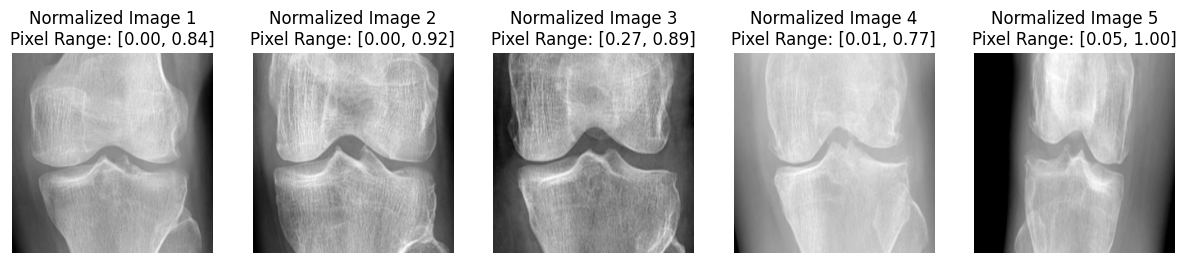

In [ ]:
# Display normalized images and their pixel value range
num_images_to_display = 5  # Number of images to display
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 3))

for i in range(num_images_to_display):
    axes[i].imshow(data_after_resize[i], cmap='gray')
    axes[i].axis('off')  # Turn off axis
    axes[i].set_title(f"Normalized Image {i+1}\nPixel Range: [{np.min(data_after_resize[i]):.2f}, {np.max(data_after_resize[i]):.2f}]")

plt.show()


In [ ]:
import numpy as np
import cv2

# Assuming 'data_after_resize' contains the resized grayscale images
# 'data_after_resize' shape: (num_images, img_size, img_size)

# Define the kernel size for Gaussian blurring
kernel_size = (5, 5)

# Create an empty list to store the preprocessed images
data_after_blur = []

# Apply Gaussian blurring to each resized grayscale image
for img in data_after_resize:
    # Apply Gaussian blurring
    blurred_img = cv2.GaussianBlur(img, kernel_size, 0)

    # Normalize the pixel values to the range [0, 1]
    blurred_img_normalized = blurred_img.astype(np.float32) / 255.0

    # Append the preprocessed image to the list
    data_after_blur.append(blurred_img_normalized)




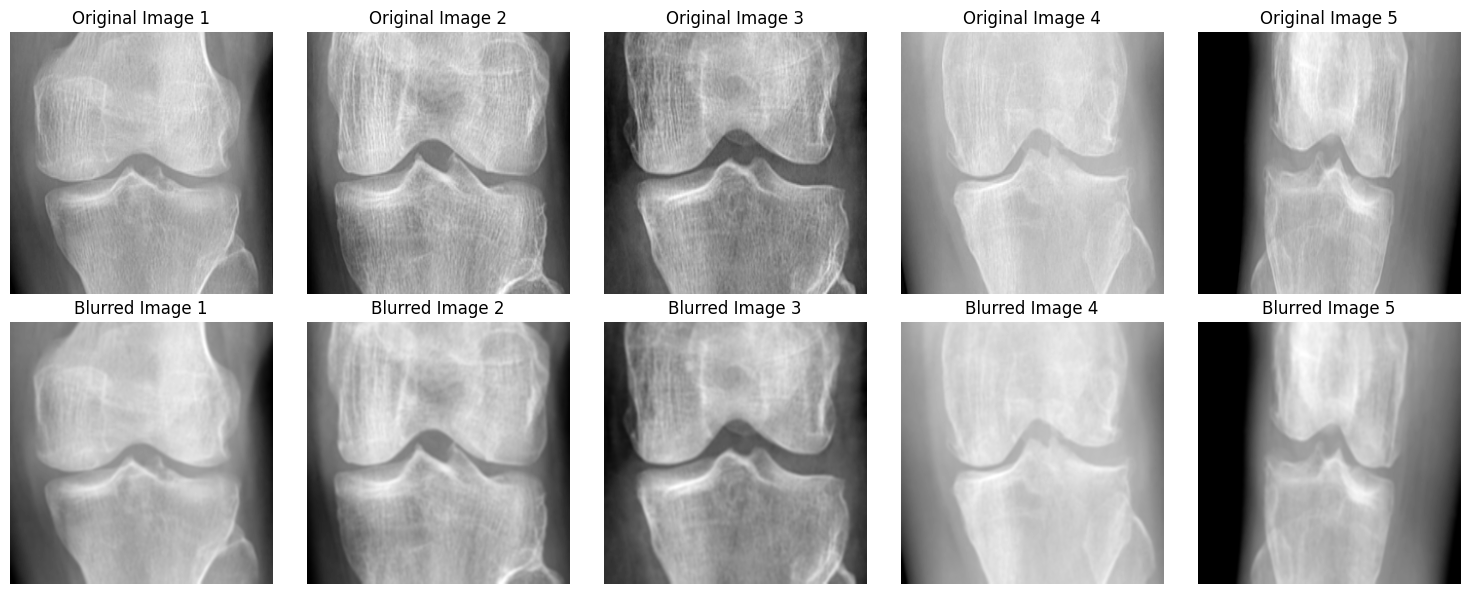

In [ ]:
  # Display a sample of original and blurred images
num_images_to_display = 5  # Number of images to display
fig, axes = plt.subplots(2, num_images_to_display, figsize=(15, 6))

for i in range(num_images_to_display):
    axes[0, i].imshow(data_after_resize[i], cmap='gray')
    axes[0, i].axis('off')  # Turn off axis
    axes[0, i].set_title(f"Original Image {i+1}")

    axes[1, i].imshow(data_after_blur[i], cmap='gray')
    axes[1, i].axis('off')  # Turn off axis
    axes[1, i].set_title(f"Blurred Image {i+1}")

plt.tight_layout()
plt.show()


In [ ]:
import os
import cv2

# Define the path to your dataset directory
dataset_path = '/content/drive/MyDrive/dataset'

# Define the path where you want to save the masks
mask_path = '/content/drive/MyDrive/dataset_masks'

# Create the mask directory if it doesn't exist
os.makedirs(mask_path, exist_ok=True)

# Loop through each category folder
for category_folder in os.listdir(dataset_path):
    category_folder_path = os.path.join(dataset_path, category_folder)
    mask_category_folder_path = os.path.join(mask_path, category_folder)
    os.makedirs(mask_category_folder_path, exist_ok=True)

    # Loop through each image in the category folder
    for image_name in os.listdir(category_folder_path):
        image_path = os.path.join(category_folder_path, image_name)

        # Load the image
        image = cv2.imread(image_path)

        # Check if the image is loaded successfully
        if image is None:
            print(f"Error loading image: {image_path}")
            continue  # Skip to the next image

        # Create a mask (example: here we create a blank mask)
        mask = 255 * (image > 0).astype('uint8')  # Example: Create a mask where non-black pixels are set to 255

        # Save the mask
        mask_name = os.path.splitext(image_name)[0] + '_mask.png'
        mask_save_path = os.path.join(mask_category_folder_path, mask_name)
        cv2.imwrite(mask_save_path, mask)

        print(f"Mask created and saved: {mask_save_path}")


Mask created and saved: /content/drive/MyDrive/dataset_masks/1Doubtful/DoubtfulG1 (315)_mask.png
Mask created and saved: /content/drive/MyDrive/dataset_masks/1Doubtful/DoubtfulG1 (314)_mask.png
Mask created and saved: /content/drive/MyDrive/dataset_masks/1Doubtful/DoubtfulG1 (313)_mask.png
Mask created and saved: /content/drive/MyDrive/dataset_masks/1Doubtful/DoubtfulG1 (319)_mask.png
Mask created and saved: /content/drive/MyDrive/dataset_masks/1Doubtful/DoubtfulG1 (329)_mask.png
Mask created and saved: /content/drive/MyDrive/dataset_masks/1Doubtful/DoubtfulG1 (325)_mask.png
Mask created and saved: /content/drive/MyDrive/dataset_masks/1Doubtful/DoubtfulG1 (323)_mask.png
Mask created and saved: /content/drive/MyDrive/dataset_masks/1Doubtful/DoubtfulG1 (321)_mask.png
Mask created and saved: /content/drive/MyDrive/dataset_masks/1Doubtful/DoubtfulG1 (333)_mask.png
Mask created and saved: /content/drive/MyDrive/dataset_masks/1Doubtful/DoubtfulG1 (332)_mask.png
Mask created and saved: /conte

In [ ]:
import os
import cv2
import numpy as np

# Define the path to your dataset directory
dataset_path = '/content/drive/MyDrive/dataset'

# Define the path where you want to save the masks
mask_path = '/content/drive/MyDrive/dataset_masks'

# Create the mask directory if it doesn't exist
os.makedirs(mask_path, exist_ok=True)

# Loop through each category folder
for category_folder in os.listdir(dataset_path):
    category_folder_path = os.path.join(dataset_path, category_folder)
    mask_category_folder_path = os.path.join(mask_path, category_folder)
    os.makedirs(mask_category_folder_path, exist_ok=True)

    # Loop through each image in the category folder
    for image_name in os.listdir(category_folder_path):
        image_path = os.path.join(category_folder_path, image_name)

        # Load the image
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

        # Check if the image is loaded successfully
        if image is None:
            print(f"Error loading image: {image_path}")
            continue  # Skip to the next image

        # Perform image processing to identify affected areas (e.g., free spaces between knee joints)
        # Example: Apply edge detection using Canny algorithm
        edges = cv2.Canny(image, 50, 150)

        # Invert the edges to get the affected areas
        affected_area = 255 - edges

        # Save the grayscale mask
        mask_name = os.path.splitext(image_name)[0] + '_mask.png'
        mask_save_path = os.path.join(mask_category_folder_path, mask_name)
        cv2.imwrite(mask_save_path, affected_area)

        print(f"Mask created and saved: {mask_save_path}")


Mask created and saved: /content/drive/MyDrive/dataset_masks/1Doubtful/DoubtfulG1 (315)_mask.png
Mask created and saved: /content/drive/MyDrive/dataset_masks/1Doubtful/DoubtfulG1 (314)_mask.png
Mask created and saved: /content/drive/MyDrive/dataset_masks/1Doubtful/DoubtfulG1 (313)_mask.png
Mask created and saved: /content/drive/MyDrive/dataset_masks/1Doubtful/DoubtfulG1 (319)_mask.png
Mask created and saved: /content/drive/MyDrive/dataset_masks/1Doubtful/DoubtfulG1 (329)_mask.png
Mask created and saved: /content/drive/MyDrive/dataset_masks/1Doubtful/DoubtfulG1 (325)_mask.png
Mask created and saved: /content/drive/MyDrive/dataset_masks/1Doubtful/DoubtfulG1 (323)_mask.png
Mask created and saved: /content/drive/MyDrive/dataset_masks/1Doubtful/DoubtfulG1 (321)_mask.png
Mask created and saved: /content/drive/MyDrive/dataset_masks/1Doubtful/DoubtfulG1 (333)_mask.png
Mask created and saved: /content/drive/MyDrive/dataset_masks/1Doubtful/DoubtfulG1 (332)_mask.png
Mask created and saved: /conte

In [ ]:
import os

def count_images_recursive(directory):
    # Initialize the counter
    num_images = 0

    # Recursively traverse the directory
    for root, dirs, files in os.walk(directory):
        # Loop through each file in the current directory
        for filename in files:
            # Check if the file has a valid image extension
            if filename.endswith('.png') or filename.endswith('.jpg'):
                # Increment the counter
                num_images += 1

    return num_images

# Define the directory paths
dataset_path = '/content/drive/MyDrive/dataset'
mask_path = '/content/drive/MyDrive/dataset_masks'

# Count the number of images in each directory (including subdirectories)
num_images_dataset = count_images_recursive(dataset_path)
num_images_masks = count_images_recursive(mask_path)

print("Total number of images in dataset directory:", num_images_dataset)
print("Total number of images in masks directory:", num_images_masks)


Total number of images in dataset directory: 4573
Total number of images in masks directory: 6223


In [ ]:
import os
import cv2

# Define the path to your dataset directory
dataset_path = '/content/drive/MyDrive/dataset'

# Define the path where you want to save the masks
mask_path = '/content/drive/MyDrive/dataset_masks'

# Create the mask directory if it doesn't exist
os.makedirs(mask_path, exist_ok=True)

# Loop through each category folder
for category_folder in os.listdir(dataset_path):
    category_folder_path = os.path.join(dataset_path, category_folder)
    mask_category_folder_path = os.path.join(mask_path, category_folder)
    os.makedirs(mask_category_folder_path, exist_ok=True)

    # Loop through each image in the category folder
    for image_name in os.listdir(category_folder_path):
        image_path = os.path.join(category_folder_path, image_name)

        # Load the image
        image = cv2.imread(image_path)

        # Check if the image is loaded successfully
        if image is None:
            print(f"Error loading image: {image_path}")
            continue  # Skip to the next image

        # Perform image processing to identify affected areas (e.g., free spaces between knee joints)
        # Example: Apply edge detection using Canny algorithm
        edges = cv2.Canny(image, 50, 150)

        # Invert the edges to get the affected areas
        affected_area = 255 - edges

        # Save the grayscale mask
        mask_name = os.path.splitext(image_name)[0] + '_mask.png'
        mask_save_path = os.path.join(mask_category_folder_path, mask_name)
        cv2.imwrite(mask_save_path, affected_area)

        print(f"Mask created and saved: {mask_save_path}")


Mask created and saved: /content/drive/MyDrive/dataset_masks/1Doubtful/DoubtfulG1 (315)_mask.png
Mask created and saved: /content/drive/MyDrive/dataset_masks/1Doubtful/DoubtfulG1 (314)_mask.png
Mask created and saved: /content/drive/MyDrive/dataset_masks/1Doubtful/DoubtfulG1 (313)_mask.png
Mask created and saved: /content/drive/MyDrive/dataset_masks/1Doubtful/DoubtfulG1 (319)_mask.png
Mask created and saved: /content/drive/MyDrive/dataset_masks/1Doubtful/DoubtfulG1 (329)_mask.png
Mask created and saved: /content/drive/MyDrive/dataset_masks/1Doubtful/DoubtfulG1 (325)_mask.png
Mask created and saved: /content/drive/MyDrive/dataset_masks/1Doubtful/DoubtfulG1 (323)_mask.png
Mask created and saved: /content/drive/MyDrive/dataset_masks/1Doubtful/DoubtfulG1 (321)_mask.png
Mask created and saved: /content/drive/MyDrive/dataset_masks/1Doubtful/DoubtfulG1 (333)_mask.png
Mask created and saved: /content/drive/MyDrive/dataset_masks/1Doubtful/DoubtfulG1 (332)_mask.png
Mask created and saved: /conte

In [ ]:
import os

# Define the paths to your dataset and mask directories
dataset_path = '/content/drive/MyDrive/dataset'
mask_path = '/content/drive/MyDrive/dataset_masks'

# Function to count the number of images in each category
def count_images_in_categories(directory):
    categories = os.listdir(directory)
    for category in categories:
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            num_images = len(os.listdir(category_path))
            print(f"Category: {category}, Number of Images: {num_images}")

# Print the number of images in each category of the dataset and mask directories
print("Dataset Categories:")
count_images_in_categories(dataset_path)
print("\nMask Categories:")
count_images_in_categories(mask_path)


In [ ]:
# Function to display images and their masks side by side
def display_images_with_masks(images, masks, category):
    # Plot the images and masks
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Display the original image
    axes[0].imshow(images[0], cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].set_axis_off()

    # Display the mask
    axes[1].imshow(masks[0], cmap='gray')
    axes[1].set_title('Mask')
    axes[1].set_axis_off()

    plt.suptitle(f'Category: {category}')
    plt.show()


In [ ]:
import matplotlib.pyplot


In [ ]:
import os
import shutil

# Define the paths to your dataset and mask directories
dataset_path = '/content/drive/MyDrive/dataset'
mask_path = '/content/drive/MyDrive/dataset_masks'

# Function to count the number of images in each category
def count_images_in_categories(directory):
    categories = os.listdir(directory)
    for category in categories:
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            num_images = len(os.listdir(category_path))
            print(f"Category: {category}, Number of Images: {num_images}")
    return categories

# Count images in dataset and mask directories
dataset_categories = count_images_in_categories(dataset_path)
mask_categories = count_images_in_categories(mask_path)

# Check and correct the number of images in each category
for category in dataset_categories:
    dataset_category_path = os.path.join(dataset_path, category)
    mask_category_path = os.path.join(mask_path, category)

    # Count images in dataset and mask directories for the current category
    num_dataset_images = len(os.listdir(dataset_category_path))
    num_mask_images = len(os.listdir(mask_category_path))

    # If the number of images does not match, print a warning and attempt to make them equal
    if num_dataset_images != num_mask_images:
        print(f"Warning: Number of images in '{category}' category does not match the number of masks.")
        if num_dataset_images > num_mask_images:
            print(f"Adding {num_dataset_images - num_mask_images} mask images to '{category}' category.")
            # Add mask images to match the number of original images
            dataset_image_files = os.listdir(dataset_category_path)
            for filename in dataset_image_files[num_mask_images:]:
                source = os.path.join(dataset_category_path, filename)
                destination = os.path.join(mask_category_path, filename.replace('.jpg', '_mask.jpg'))
                shutil.copy(source, destination)
        else:
            print(f"Adding {num_mask_images - num_dataset_images} original images to '{category}' category.")
            # Add original images to match the number of mask images
            mask_image_files = os.listdir(mask_category_path)
            for filename in mask_image_files[num_dataset_images:]:
                source = os.path.join(mask_category_path, filename)
                destination = os.path.join(dataset_category_path, filename.replace('_mask.jpg', '.jpg'))
                shutil.copy(source, destination)


Category: 1Doubtful, Number of Images: 1453
Category: 4Severe, Number of Images: 607
Category: 3Moderate, Number of Images: 663
Category: 0Normal, Number of Images: 1155
Category: 2Mild, Number of Images: 695
Category: 1Doubtful, Number of Images: 1941
Category: 4Severe, Number of Images: 813
Category: 3Moderate, Number of Images: 884
Category: 0Normal, Number of Images: 1658
Category: 2Mild, Number of Images: 927
Adding 488 original images to '1Doubtful' category.
Adding 206 original images to '4Severe' category.
Adding 221 original images to '3Moderate' category.
Adding 503 original images to '0Normal' category.
Adding 232 original images to '2Mild' category.


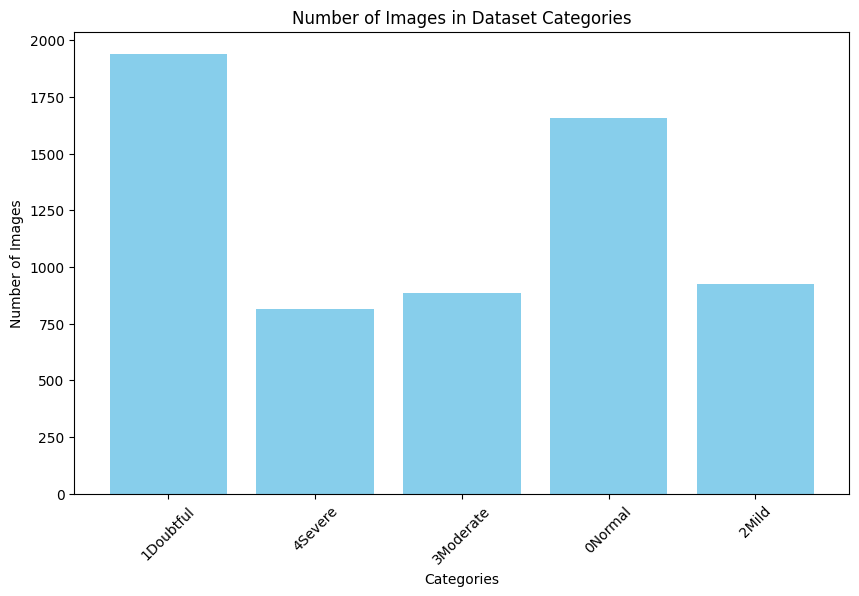

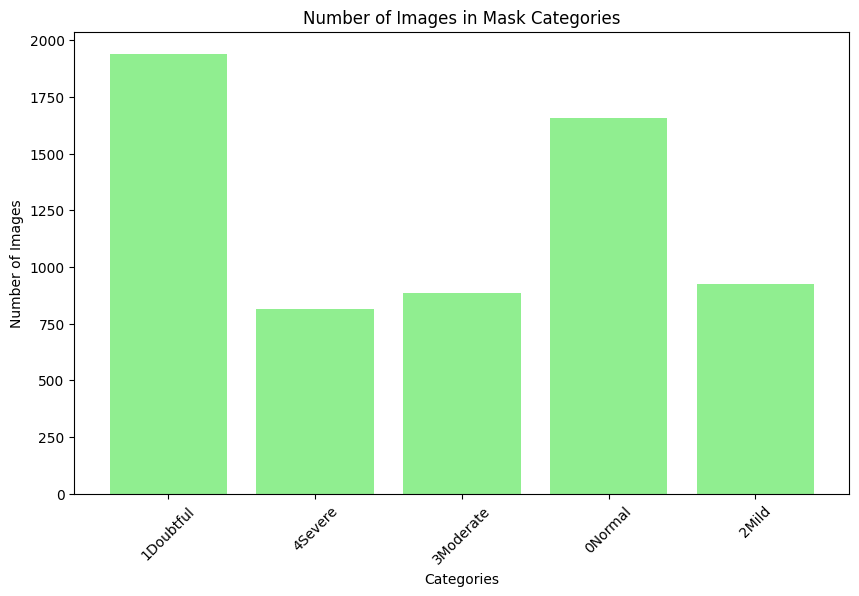

In [ ]:
import os
import matplotlib.pyplot as plt

# Define the paths to your dataset and mask directories
dataset_path = '/content/drive/MyDrive/dataset'
mask_path = '/content/drive/MyDrive/dataset_masks'

# Function to count the number of images in each category
def count_images_in_categories(directory):
    categories = os.listdir(directory)
    category_names = []
    num_images = []
    for category in categories:
        category_path = os.path.join(directory, category)
        if os.path.isdir(category_path):
            category_names.append(category)
            num_images.append(len(os.listdir(category_path)))
    return category_names, num_images

# Get the category names and number of images for both dataset and mask directories
dataset_categories, dataset_counts = count_images_in_categories(dataset_path)
mask_categories, mask_counts = count_images_in_categories(mask_path)

# Plotting the bar chart for dataset categories
plt.figure(figsize=(10, 6))
plt.bar(dataset_categories, dataset_counts, color='skyblue')
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Number of Images in Dataset Categories')
plt.xticks(rotation=45)
plt.show()

# Plotting the bar chart for mask categories
plt.figure(figsize=(10, 6))
plt.bar(mask_categories, mask_counts, color='lightgreen')
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Number of Images in Mask Categories')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Function to load images from a directory
def load_images_from_dir(directory):
    images = []
    for filename in os.listdir(directory):
        img = cv2.imread(os.path.join(directory, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
    return images


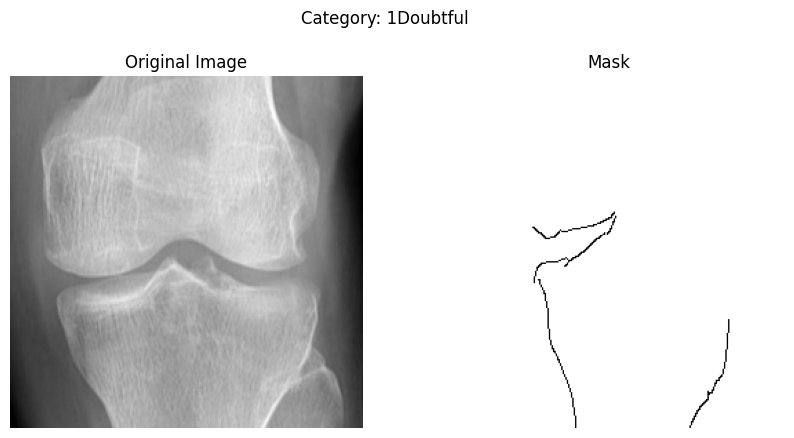

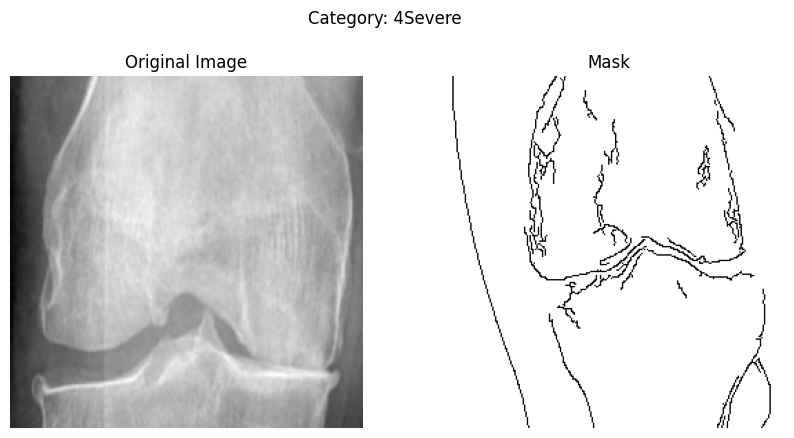

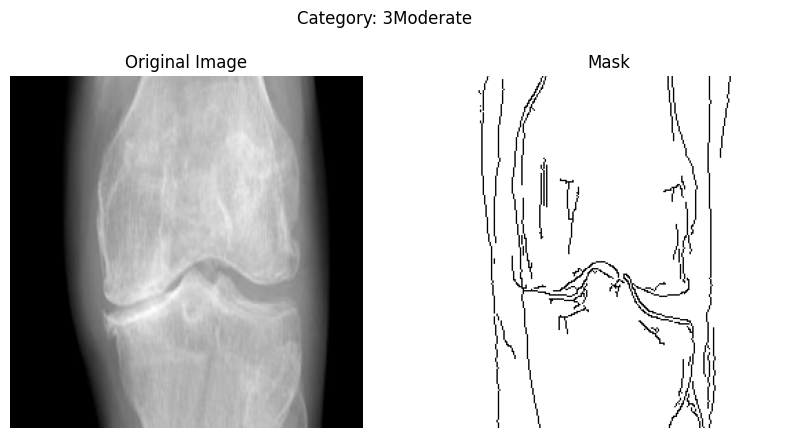

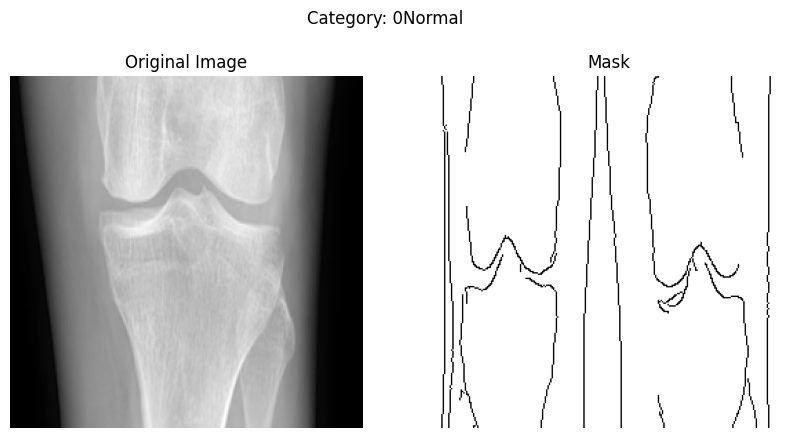

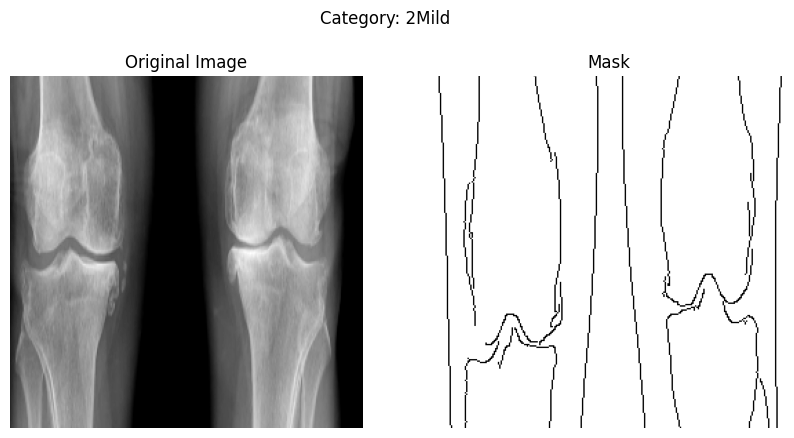

In [ ]:
# Loop through each category folder in the dataset directory
for category_folder in os.listdir(dataset_path):
    category_folder_path = os.path.join(dataset_path, category_folder)
    mask_category_folder_path = os.path.join(mask_path, category_folder)

    # Load original images and mask images
    original_images = load_images_from_dir(category_folder_path)
    mask_images = load_images_from_dir(mask_category_folder_path)

    # Display the first image and its mask if available
    if original_images and mask_images:
        display_images_with_masks([original_images[0]], [mask_images[0]], category_folder)
    else:
        print(f"No images or masks found in category: {category_folder}")


In [ ]:
from tensorflow.keras.models import load_model

# Define the path to your pretrained U-Net model
pretrained_model_path = '/content/drive/MyDrive/Pre-Trained Model.h5'

# Load the pretrained U-Net model
pretrained_model = load_model(pretrained_model_path)

# Print the summary of the pretrained U-Net model
pretrained_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 batch_normalization_v1 (Ba  (None, 1024)              4096      
 tchNormalization)                                               
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 128)               131200    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 136586 (533.54 KB)
Trainable params: 134538 (525.54 KB)
Non-trainable params: 2048 (8.00 KB)
_______________

In [ ]:
# Check the lengths of data_after_blur and labels arrays
print("Number of images:", len(data_after_blur))
print("Number of labels:", len(labels))


Number of images: 4573
Number of labels: 5


In [ ]:
import numpy as np
import cv2

# Define the path to your dataset directory
dataset_path = '/content/drive/MyDrive/dataset'

# Define the path where you want to save the masks
mask_path = '/content/drive/MyDrive/dataset_masks'

# Create the mask directory if it doesn't exist
os.makedirs(mask_path, exist_ok=True)

# Create an empty list to store the preprocessed images
data_after_blur = []

# Loop through each category folder
for category_folder in os.listdir(dataset_path):
    category_folder_path = os.path.join(dataset_path, category_folder)
    mask_category_folder_path = os.path.join(mask_path, category_folder)
    os.makedirs(mask_category_folder_path, exist_ok=True)

    # Loop through each image in the category folder
    for image_name in os.listdir(category_folder_path):
        image_path = os.path.join(category_folder_path, image_name)

        # Load the image
        image = cv2.imread(image_path)

        # Check if the image is loaded successfully
        if image is None:
            print(f"Error loading image: {image_path}")
            continue  # Skip to the next image

        # Perform Gaussian blurring
        blurred_img = cv2.GaussianBlur(image, (5, 5), 0)

        # Normalize the pixel values to the range [0, 1]
        blurred_img_normalized = blurred_img.astype(np.float32) / 255.0

        # Append the preprocessed image to the list
        data_after_blur.append(blurred_img_normalized)

# Convert the list of preprocessed images to a numpy array
data_after_blur = np.array(data_after_blur)

# Display a sample of original and blurred images
num_images_to_display = 5  # Number of images to display
fig, axes = plt.subplots(2, num_images_to_display, figsize=(15, 6))

for i in range(num_images_to_display):
    axes[0, i].imshow(cv2.cvtColor(data_before_resize[i], cv2.COLOR_BGR2RGB))
    axes[0, i].axis('off')  # Turn off axis
    axes[0, i].set_title(f"Original Image {i+1}")

    axes[1, i].imshow(data_after_blur[i], cmap='gray')
    axes[1, i].axis('off')  # Turn off axis
    axes[1, i].set_title(f"Blurred Image {i+1}")

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

# Generate sample labels corresponding to each image
# Assuming each image has a unique label
num_images = len(data_after_blur)
sample_labels = np.arange(num_images)

# Check the number of generated labels
print("Number of generated labels:", len(sample_labels))


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data_after_blur, sample_labels, test_size=0.2, random_state=42)

# Check the shapes of the split datasets
print("Training data shape:", X_train.shape, y_train.shape)
print("Validation data shape:", X_val.shape, y_val.shape)


In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(data_after_blur, labels, test_size=0.2, random_state=42)

# Check the shapes of the split datasets
print("Training data shape:", X_train.shape, y_train.shape)
print("Validation data shape:", X_val.shape, y_val.shape)


In [ ]:
# Assuming X_train, y_train, X_val, y_val are your training and validation data
# Split the data into training and validation sets (you can replace X_val and y_val with your actual validation data)
X_train, X_val, y_train, y_val = train_test_split(data_after_blur, labels, test_size=0.2, random_state=42)

# Convert the data to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)

# Reshape the data if necessary (depends on the model input requirements)
# For example, if the model expects 4D input with shape (batch_size, height, width, channels)
# You might need to reshape the data like this:
# X_train = X_train.reshape(-1, img_size, img_size, 1)
# X_val = X_val.reshape(-1, img_size, img_size, 1)

# Print the shapes of training and validation data
print("Training data shape:", X_train.shape, y_train.shape)
print("Validation data shape:", X_val.shape, y_val.shape)

# Now you can proceed with the next steps such as defining the model, compiling it, training, and evaluation.
